# Analysis of homogenized temperature data from the Netherlands

This notebook contains some Python code to analyze the [Central Netherlands Temperature](https://www.clim-past.net/7/527/2011/cp-7-527-2011.html) (CNT), a monthly mean temperature series constructed from homogenized time series from various weather stations operated by the [KNMI](https://www.knmi.nl) in the Netherlands. The complete CNT data set from 1906 onwards is publicly available [here](http://projects.knmi.nl/klimatologie/onderzoeksgegevens/CNT/tg_CNT.txt). 

## Import prerequisites:

In [1]:
import calendar
import datetime
import time

import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import seaborn

from scipy.optimize import curve_fit

from bokeh.io       import show, output_notebook
from bokeh.layouts  import layout
from bokeh.models   import HoverTool, Range1d, ColumnDataSource, Whisker
from bokeh.palettes import d3
from bokeh.plotting import figure

output_notebook()

plt.style.use('classic')

pd.set_option('display.max_columns', 40)
#pd.set_option('precision', 2)
#pd.set_option('display.float_format', '{:06.5f}'.format)

mycolors  = [d3['Category10'][10][i] for i in range(10)]
mycolors2 = [d3['Category20'][20][i] for i in range(20)]

%load_ext watermark
%watermark -a "Author: gmalim" 
print("")
%watermark -u -n
print("")
%watermark -v -p numpy,pandas,scipy,matplotlib,bokeh
print("")
%watermark -m

/Users/uci/.pyenv/versions/3.6.5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Loading BokehJS ...

Author: gmalim

last updated: Thu Aug 16 2018

CPython 3.6.5
IPython 6.5.0

numpy 1.15.0
pandas 0.23.4
scipy 1.1.0
matplotlib 2.2.3
bokeh 0.13.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 2
interpreter: 64bit


## Data processing

Load data:

In [2]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

df_months = pd.read_csv('tg_CNT.txt', skiprows=12, sep=' ', skipinitialspace=True, names=['year', *months])

print(df_months.shape)
display(df_months.head())
display(df_months.tail())

(113, 13)


,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1906,3.32429,2.29741,3.78348,7.65619,12.4297,14.1998,16.7496,16.9169,13.2947,11.69020,7.56198,-0.21912
1,1907,1.51254,0.40494,4.58511,7.41965,12.5166,13.5531,13.8619,15.4620,13.7227,11.26630,5.63488,3.13986
2,1908,-1.24001,3.30636,3.43674,5.86811,12.9866,16.2455,16.6096,15.0095,13.3625,9.81094,4.28813,1.02190
3,1909,0.55002,0.29838,2.95708,8.53574,11.3026,12.9562,14.5315,16.2449,12.9722,10.97730,3.93653,3.07201
4,1910,3.27844,4.02948,5.25129,7.83671,12.4597,16.0278,15.1130,16.1327,13.2861,10.39700,3.35544,5.40469


,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
108,2014,5.40054,6.36905,8.32527,12.04556,13.17419,16.11667,19.63065,15.87312,15.69167,13.27043,8.07111,4.32419
109,2015,3.52419,2.96488,5.89946,9.00889,12.40806,15.89389,18.58817,18.79032,13.31944,9.72957,9.57056,9.37688
110,2016,4.44624,4.28678,5.12903,8.56889,14.58548,17.06056,18.43387,17.90591,17.33611,9.65215,5.34246,4.35161
111,2017,0.93280,5.11369,8.66613,8.28889,15.28172,18.50444,18.15753,17.44677,13.71833,13.04624,6.70667,4.59247
112,2018,5.44355,0.18690,4.65645,12.45889,16.71935,17.79889,21.43602,NaN,NaN,NaN,NaN,NaN


Print dataframe statistics:

In [3]:
display(df_months.describe().round(1))

,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
count,113.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,112.0,112.0,112.0,112.0,112.0
mean,1962.0,2.2,2.5,5.2,8.5,12.7,15.4,17.2,16.8,14.1,10.1,5.8,3.1
std,32.8,2.6,2.7,1.8,1.6,1.4,1.4,1.6,1.3,1.3,1.5,1.7,2.2
min,1906.0,-6.2,-7.0,1.8,4.5,9.6,11.2,13.8,13.9,10.4,6.0,1.0,-2.6
25%,1934.0,0.7,1.3,3.9,7.5,11.8,14.6,16.2,15.9,13.3,9.2,4.9,2.1
50%,1962.0,2.5,2.9,5.1,8.5,12.8,15.4,17.0,16.7,14.0,10.1,5.8,3.5
75%,1990.0,4.0,4.4,6.6,9.2,13.7,16.3,18.0,17.7,14.7,11.2,6.8,4.6
max,2018.0,6.6,7.4,8.7,13.0,16.7,18.5,22.6,20.4,17.8,14.1,9.8,9.4


Unpivot multi-column dataframe into single-column dataframe:

In [4]:
df_dates = df_months.melt(id_vars=['year'], var_name='month', value_name='CNT')

print(df_dates.shape)
display(df_dates.head())
display(df_dates.tail())

(1356, 3)


,year,month,CNT
0,1906,Jan,3.32429
1,1907,Jan,1.51254
2,1908,Jan,-1.24001
3,1909,Jan,0.55002
4,1910,Jan,3.27844


,year,month,CNT
1351,2014,Dec,4.32419
1352,2015,Dec,9.37688
1353,2016,Dec,4.35161
1354,2017,Dec,4.59247
1355,2018,Dec,NaN


Define function to create date of type *datetime*:

In [5]:
def create_date(row):
    for monthindex, month in enumerate(months, 1):
        if row['month'] == month:
            return '{}-{}-{}'.format(row['year'],  monthindex, 15)

Create data column, drop NANs, sort by date and reset index of dataframe:

In [6]:
# Create new DATE column and set type:

df_dates['DATE'] = df_dates.apply(create_date, axis=1)
df_dates['DATE'] = df_dates['DATE'].astype('datetime64[D]')

# Drop rows with NANs:

df_dates.dropna(inplace=True)

# Sort dataframe by DATE column:

df_dates = df_dates.sort_values(by=['DATE'])

# Reset index and drop old index:

df_dates = df_dates.reset_index(drop=True)

# Select and order columns:

df_dates = df_dates[['DATE', 'CNT']]

print(df_dates.shape)
display(df_dates.head())
display(df_dates.tail())

(1351, 2)


,DATE,CNT
0,1906-01-15,3.32429
1,1906-02-15,2.29741
2,1906-03-15,3.78348
3,1906-04-15,7.65619
4,1906-05-15,12.42970


,DATE,CNT
1346,2018-03-15,4.65645
1347,2018-04-15,12.45889
1348,2018-05-15,16.71935
1349,2018-06-15,17.79889
1350,2018-07-15,21.43602


Select time period:

In [7]:
df_dates = df_dates.set_index('DATE')

start_year = 1906
end_year   = 2018

start_date = '{}-01-01'.format(start_year)
end_date   = '{}-12-31'.format(end_year)

df_dates = df_dates.loc[start_date:end_date]

df_dates = df_dates.reset_index()

print(df_dates.shape)

(1351, 2)


Print dataframe statistics:

In [8]:
display(df_dates.describe().round(1))

,CNT
count,1351.0
mean,9.5
std,5.7
min,-7.0
25%,4.7
50%,9.3
75%,14.7
max,22.6


Plot data:

In [9]:
tools = "pan,wheel_zoom,box_zoom,reset,hover,save"

fig1 = figure(plot_width=900, plot_height=450, x_axis_type='datetime', tools=tools, toolbar_location='above')
fig1.title.text = "Central Netherlands Temperature {}-{}".format(start_year, end_year)
fig1.background_fill_color = '#eeeeee'
fig1.grid.grid_line_color = 'white'   
fig1.xaxis.axis_label = "Date"
fig1.yaxis.axis_label = "Central Netherlands Temperature (C)"
fig1.x_range=Range1d(pd.to_datetime('1900'), pd.to_datetime('2024'))
fig1.y_range=Range1d(-10,25)

source_data = ColumnDataSource(data=df_dates)

fig1.circle(x='DATE', y='CNT', source=source_data, size=5, color=mycolors[0], alpha=0.5)

hover = fig1.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [("Date", "@DATE{%F}"    ),
                  ("CNT",  "@CNT{0.0 a} C")]
hover.formatters = {'DATE':'datetime'}

mylayout = layout(fig1)

show(mylayout, notebook_handle=True);

# Temperature distributions per month

Create Gaussian function:

In [10]:
def mygaussian(x, ampl, mu, sigma):
    return ampl*np.exp(-(x-mu)**2/(2*sigma**2))

pg_min = ( 1, -10,  0.5)
pg_max = (50,  30, 10.0)
pg_bounds = (pg_min, pg_max)

Fit monthly temperature distributions with Gaussian functions:

Fitted Gaussian (Jan): 10.1*exp(-(x- 2.8)^2/(2*2.1^2))
Fitted Gaussian (Feb):  9.7*exp(-(x- 3.1)^2/(2*2.3^2))
Fitted Gaussian (Mar): 11.6*exp(-(x- 5.3)^2/(2*2.0^2))
Fitted Gaussian (Apr): 16.1*exp(-(x- 8.5)^2/(2*1.3^2))
Fitted Gaussian (May): 15.1*exp(-(x-12.8)^2/(2*1.5^2))
Fitted Gaussian (Jun): 17.8*exp(-(x-15.4)^2/(2*1.2^2))
Fitted Gaussian (Jul): 15.7*exp(-(x-17.0)^2/(2*1.4^2))
Fitted Gaussian (Aug): 17.4*exp(-(x-16.7)^2/(2*1.3^2))
Fitted Gaussian (Sep): 19.1*exp(-(x-13.9)^2/(2*1.1^2))
Fitted Gaussian (Oct): 16.1*exp(-(x-10.2)^2/(2*1.3^2))
Fitted Gaussian (Nov): 15.1*exp(-(x- 5.9)^2/(2*1.4^2))
Fitted Gaussian (Dec): 12.1*exp(-(x- 3.7)^2/(2*1.7^2))


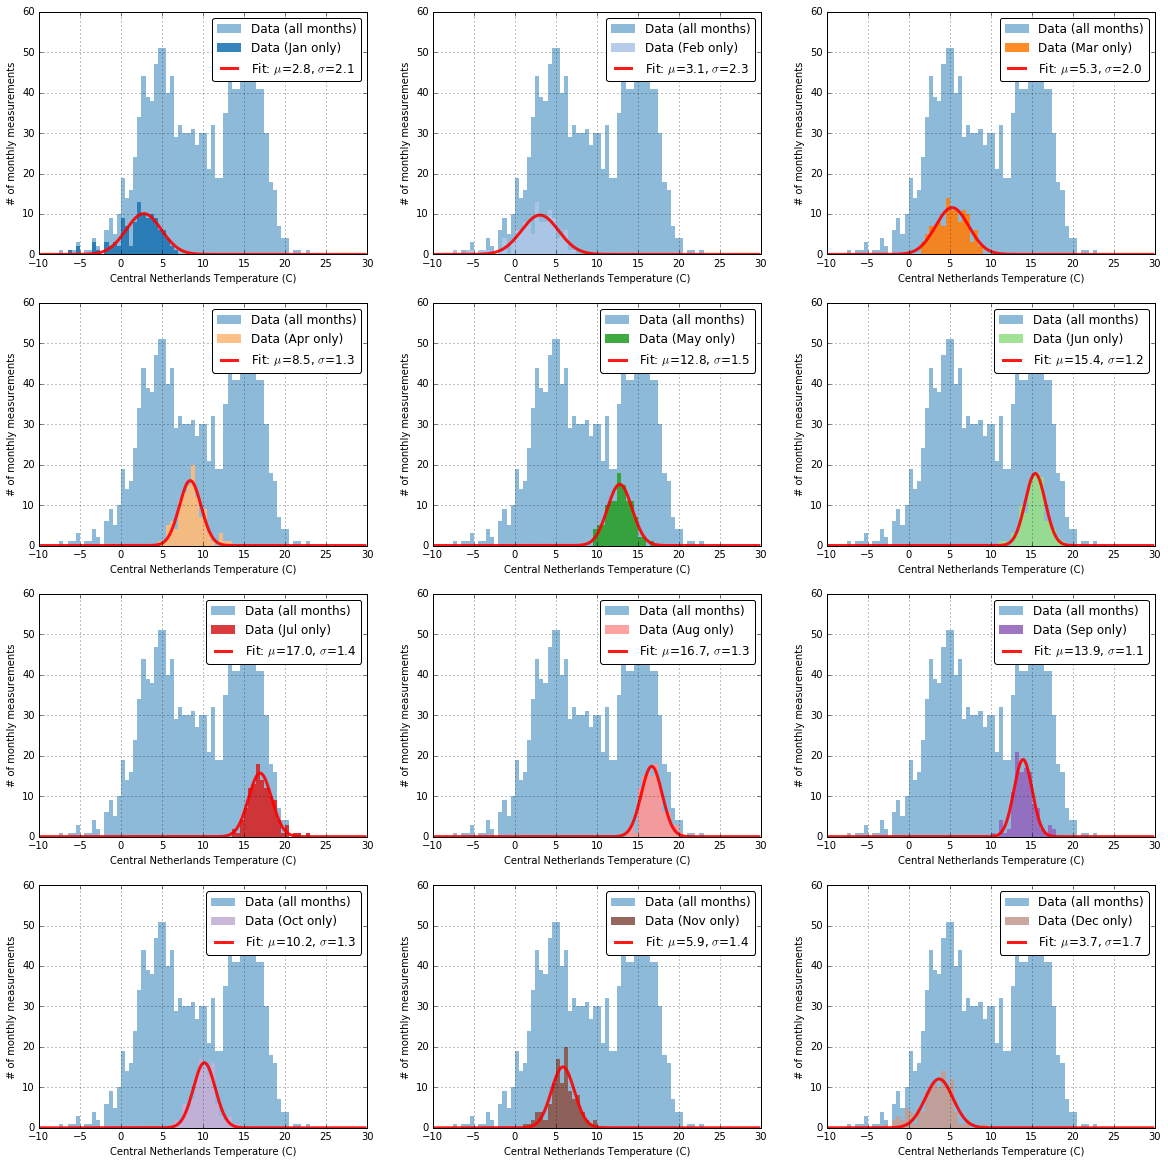

In [11]:
plt.figure(figsize=(20, 20))

n_data     = []
mu_data    = []
mu_fit     = []
sigma_data = []
sigma_fit  = []

nbins = 80
fitrange = (-10,30)

for i, month in enumerate(months, 1):

    plt.subplot(4, 3, i)
    
    plt.hist(x=df_dates.CNT, range=fitrange, bins=nbins, alpha=0.5, color=mycolors[0], lw=0, label='Data (all months)')
    
    df_month = df_months[month]
    df_month.dropna(inplace=True)
        
    n_data.append(df_month.count())
    mu_data.append(df_month.mean())
    sigma_data.append(df_month.std())
        
    bincontents_tmp, binedges_tmp, _ = plt.hist(x=df_months[month], range=fitrange, bins=nbins,
                                                color=mycolors2[i-1], lw=0, alpha=0.9, 
                                                label='Data ({} only)'.format(month))
    
    bincentralvalues_tmp = [(binedges_tmp[i]+binedges_tmp[i+1])/2 for i in range(len(binedges_tmp)-1)]
    
    #plt.axvline(x=df_month.mean(), linestyle='--', lw=3, color=mycolors2[i-1], 
    #            label='Mean {} data ({:.1f} C)'.format(month, df_month.mean()))
        
    x_data_tmp = bincentralvalues_tmp
    y_data_tmp = bincontents_tmp
    
    pg_start_tmp = [15, df_months[month].mean(), 2]

    pg_opt_tmp, pg_cov_tmp = curve_fit(mygaussian, x_data_tmp, y_data_tmp, p0=pg_start_tmp, bounds=pg_bounds)

    mu_fit   .append(pg_opt_tmp[1])
    sigma_fit.append(pg_opt_tmp[2])
    
    print("Fitted Gaussian ({}): {:4.1f}*exp(-(x-{:4.1f})^2/(2*{:.1f}^2))".format(month, *pg_opt_tmp))
    
    x_fit_tmp = np.linspace(min(x_data_tmp), max(x_data_tmp), num=len(x_data_tmp)*10)
    y_fit_tmp = mygaussian(x_fit_tmp, *pg_opt_tmp)

    plt.plot(x_fit_tmp, y_fit_tmp, lw=3, color='red', alpha=0.9,
             label="Fit: $\mu$={:.1f}, $\sigma$={:.1f}".format(pg_opt_tmp[1], pg_opt_tmp[2]))
    
    handles, labels = plt.gca().get_legend_handles_labels()
    myorder = [1, 2, 0]
    handles = [handles[i] for i in myorder]
    labels  = [labels [i] for i in myorder]

    plt.legend(handles, labels, loc='upper right', fancybox=True)
    plt.ylabel('# of monthly measurements')
    plt.xlabel('Central Netherlands Temperature (C)')
    plt.grid(True)

Create fit function which encapsulates *curve_fit* call and reduced $\chi^2$ calculation:

In [12]:
def myfitfunction(myfunc, x_data, y_data, y_sigma, p_start, p_bounds, verbose):
    
    p_opt, p_cov = curve_fit(myfunc, x_data, y_data, p0=p_start, bounds=p_bounds, sigma=y_sigma, absolute_sigma=True)

    p_std = np.sqrt(np.diag(p_cov))
    y_fit = myfunc(x_data, *p_opt)
    res   = y_data - y_fit
    chi2  = np.sum((res/y_sigma)**2)
    ndata = len(x_data)
    npfit = len(p_opt)
    rchi2 = chi2/(ndata - npfit)

    if verbose: 
        print("--> Fitted parameters:")
        print(p_opt.round(3))
        print("")
        print("--> Covariance matrix:")
        print(p_cov)
        print("")
        print("--> Fitted parameter standard deviations:")
        print(p_std.round(3))
        print("")
        print('--> rchi2 = chi2/ndf = {:.2f}/({:d}-{:d}) = {:.2f}'.format(chi2, ndata, npfit, rchi2))
        
    return p_opt, p_std, rchi2

Create sine function:

In [13]:
# x in months, period of 1 year is fixed:

def myfunc0(x, ampl, hoffset, voffset):
    return  ampl*np.sin(2*np.pi*(x - hoffset)/12) + voffset

p0_start = [1, 0, 0]
p0_min = (     0,  0, -np.inf)
p0_max = (np.inf, 12,  np.inf)
p0_bounds = (p0_min, p0_max)

Fit mean monthly temperature distribution with sine function:

In [14]:
x_data = [i[0] for i in list(enumerate(months, 1))]
#y_data = mu_data
y_data = mu_fit
#y_sigma = sigma_data/np.sqrt(n_data) # sigma_mean = sigma/sqrt(N)
y_sigma = sigma_fit/np.sqrt(n_data) # sigma_mean = sigma/sqrt(N)

p0_opt, p0_std, rchi2_0 = myfitfunction(myfunc0, x_data, y_data, y_sigma, p0_start, p0_bounds, True)

--> Fitted parameters:
[7.468 4.188 9.534]

--> Covariance matrix:
[[ 3.82137113e-03  3.09088849e-05 -8.36586504e-04]
 [ 3.09088849e-05  1.90719156e-04 -6.74922981e-05]
 [-8.36586504e-04 -6.74922981e-05  1.76599186e-03]]

--> Fitted parameter standard deviations:
[0.062 0.014 0.042]

--> rchi2 = chi2/ndf = 58.03/(12-3) = 6.45


Create fitted function values:

In [15]:
x_fit = np.linspace(0, 12, num=100)
y_fit = myfunc0(x_fit, *p0_opt)

Plot mean monthly temperatures & fitted sine function, and the monthly temperature range ($\mu \pm \sigma$):

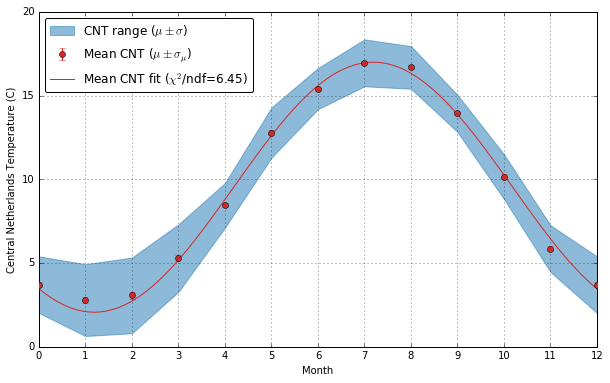

In [16]:
plt.figure(figsize=(10,6))
plt.grid(True)

# Data:

x = x_data[:]
y = y_data[:]

y_err = list(y_sigma)

min_temp = list(np.subtract(y, sigma_fit))
#min_temp = list(np.subtract(y, sigma_data))
max_temp = list(np.add     (y, sigma_fit)) 
#max_temp = list(np.add     (y, sigma_data))

x.insert(0, 0)
y.insert(0, y[-1])
y_err.insert(0, y_err[-1])
min_temp.insert(0, min_temp[-1])
max_temp.insert(0, max_temp[-1])

plt.fill_between(x, min_temp, max_temp, color=mycolors[0], alpha=0.5, label='CNT range ($\mu\pm\sigma$)')
plt.errorbar(x, y, yerr=y_err, color=mycolors[3], fmt='o', zorder=10, label='Mean CNT ($\mu\pm\sigma_\mu$)')

# Fit:

plt.plot(x_fit, y_fit, color=mycolors[3], label='Mean CNT fit ($\chi^2$/ndf={:.2f})'.format(rchi2_0), zorder=10)

# Legend:

handles, labels = plt.gca().get_legend_handles_labels()
myorder = [1, 2, 0]
handles = [handles[i] for i in myorder]
labels  = [labels [i] for i in myorder]

plt.legend(handles, labels, loc='upper left', fancybox=True, numpoints=1)

# Axes:

plt.xticks(x)
plt.xlabel('Month')
plt.ylabel('Central Netherlands Temperature (C)')
plt.xlim(0, 12)
plt.ylim(0, 20)

plt.show()

# Monthly trend fits

Create additional dataframe rows:

In [17]:
# Temperature measurement error is taken as standard deviation from Gaussian fit to monthly temperature distribution:

def create_sigma(row):
    date = row['DATE']
    monthindex = int(date.strftime('%m'))
    #sigma = sigma_data[monthindex-1]
    sigma = sigma_fit[monthindex-1]
    return sigma

df_dates['sigma'] = df_dates.apply(create_sigma, axis=1)

In [18]:
# Timestamp (i.e. number of seconds since 1970-1-1) is added since dates can't be directly used in curve_fit:

def create_timestamp(row):
    date = row['DATE']
    timestamp = calendar.timegm(date.timetuple())
    return timestamp

df_dates['timestamp'] = df_dates.apply(create_timestamp, axis=1)

print("--> timestamp = 0 <=> Date =", time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.gmtime(0)))

--> timestamp = 0 <=> Date = Thu, 01 Jan 1970 00:00:00 +0000


Create fit functions:

In [19]:
P = int(3600*24*365.25)
print("--> Number of seconds per year = {:d}".format(P))

--> Number of seconds per year = 31557600


In [20]:
def myfunc1(x, voffset): # Constant function (x is given in seconds)
    return voffset

p_start_1 = [9.5]
p_min = (-np.inf)
p_max = ( np.inf)
p_bounds_1 = (p_min, p_max)

In [21]:
def myfunc2(x, slope, voffset): # 1st order polynomial (x is given in seconds)
    #return slope*x + voffset
    return slope*x/P + voffset

p_start_2 = [0, 9.5]
p_min = (-np.inf, -np.inf)
p_max = ( np.inf,  np.inf)
p_bounds_2 = (p_min, p_max)

In [22]:
def myfunc3(x, base, voffset): # Exponential function (x is given in seconds)
    #return (np.exp(b*x/P)-1) + voffset
    return (np.power(base,x/P)-1) + voffset

p_start_3 = [1, 9.5]
p_min = (-np.inf, -np.inf)
p_max = ( np.inf,  np.inf)
p_bounds_3 = (p_min, p_max)

Fit monthly temperature-time distributions:

In [23]:
p_opt_1_months = []
p_err_1_months = []
rchi2_1_months = []

p_opt_2_months = []
p_err_2_months = []
rchi2_2_months = []

p_opt_3_months = []
p_err_3_months = []
rchi2_3_months = []

for i, month in enumerate(months, 1):
    
    print("{:-^72s}".format(" {} ".format(month)))
    print("")

    mask = (df_dates['DATE'].dt.month == i)
    df = df_dates.loc[mask]

    x_data  = df.timestamp
    y_data  = df.CNT
    y_sigma = df.sigma

    print("==> Constant function fit:")
    print("")
    p_opt_1, p_std_1, rchi2_1 = myfitfunction(myfunc1, x_data, y_data, y_sigma, p_start_1, p_bounds_1, True)
    print("")
    print("==> 1st order polynomial fit:")
    print("")
    p_opt_2, p_std_2, rchi2_2 = myfitfunction(myfunc2, x_data, y_data, y_sigma, p_start_2, p_bounds_2, True)
    print("")
    print("==> Exponential function fit:")
    print("")
    p_opt_3, p_std_3, rchi2_3 = myfitfunction(myfunc3, x_data, y_data, y_sigma, p_start_3, p_bounds_3, True)
    print("")
    
    p_opt_1_months.append(p_opt_1)
    p_err_1_months.append(p_std_1)
    rchi2_1_months.append(rchi2_1)
    
    p_opt_2_months.append(p_opt_2)
    p_err_2_months.append(p_std_2)
    rchi2_2_months.append(rchi2_2)
    
    p_opt_3_months.append(p_opt_3)
    p_err_3_months.append(p_std_3)
    rchi2_3_months.append(rchi2_3)

--------------------------------- Jan ----------------------------------

==> Constant function fit:

--> Fitted parameters:
[2.181]

--> Covariance matrix:
[[0.04070873]]

--> Fitted parameter standard deviations:
[0.202]

--> rchi2 = chi2/ndf = 162.42/(113-1) = 1.45

==> 1st order polynomial fit:

--> Fitted parameters:
[0.014 2.29 ]

--> Covariance matrix:
[[3.82600603e-05 3.04626959e-04]
 [3.04626959e-04 4.31341728e-02]]

--> Fitted parameter standard deviations:
[0.006 0.208]

--> rchi2 = chi2/ndf = 157.51/(113-2) = 1.42

==> Exponential function fit:

--> Fitted parameters:
[1.018 2.156]

--> Covariance matrix:
[[ 3.07350305e-05 -3.10991347e-04]
 [-3.10991347e-04  4.38554856e-02]]

--> Fitted parameter standard deviations:
[0.006 0.209]

--> rchi2 = chi2/ndf = 155.54/(113-2) = 1.40

--------------------------------- Feb ----------------------------------

==> Constant function fit:

--> Fitted parameters:
[2.54]

--> Covariance matrix:
[[0.04528177]]

--> Fitted parameter standar

Create fitted function values:

In [24]:
x_fit = np.linspace(min(x_data), max(x_data), num=(len(x_data)*10))
 
x_fit_date = []

for i in x_fit:
    date = time.strftime("%Y-%m-%d", time.gmtime(i))
    date = pd.to_datetime(date)
    x_fit_date.append(date)

y_fit_1_months = []
y_fit_2_months = []
y_fit_3_months = []

for i, month in enumerate(months, 1):
    
    y_fit_1 = myfunc1(x_fit, *p_opt_1_months[i-1])
    y_fit_2 = myfunc2(x_fit, *p_opt_2_months[i-1])
    y_fit_3 = myfunc3(x_fit, *p_opt_3_months[i-1])

    y_fit_1_months.append(y_fit_1)
    y_fit_2_months.append(y_fit_2)
    y_fit_3_months.append(y_fit_3)

Plot monthly temperature-time distributions and fitted functions:

In [25]:
tools = "pan,wheel_zoom,box_zoom,reset,save"

source_error = ColumnDataSource(data=dict(base=df_dates.DATE, 
                                          lower=(df_dates.CNT - df_dates.sigma), 
                                          upper=(df_dates.CNT + df_dates.sigma)))

In [26]:
title = "Central Netherlands Temperature {}-{} per month, fitted with constant functions".format(start_year, end_year)

fig1 = figure(plot_width=900, plot_height=450, x_axis_type='datetime', tools=tools, toolbar_location='above')
fig1.title.text = title
fig1.background_fill_color = '#eeeeee'
fig1.grid.grid_line_color = 'white'   
fig1.xaxis.axis_label = "Date"
fig1.yaxis.axis_label = "Central Netherlands Temperature (C)"
fig1.x_range=Range1d(pd.to_datetime('1900'), pd.to_datetime('2035'))
fig1.y_range=Range1d(-10,25)

w = Whisker(source=source_error, base="base", upper="upper", lower="lower", line_color='grey', line_alpha=0.1)
#w.upper_head.line_color = 'grey'
#w.lower_head.line_color = 'grey'
#w.upper_head.line_alpha = 0.5
#w.lower_head.line_alpha = 0.5
w.upper_head = None
w.lower_head = None
fig1.add_layout(w)

fig1.circle(x='DATE', y='CNT', source=source_data, size=5, color='grey', alpha=0.1)

for i, month in enumerate(months, 1):
    
    mask = (df_dates['DATE'].dt.month == i)
    df = df_dates.loc[mask]
    
    fig1.circle(x=df.DATE, y=df.CNT, color=mycolors2[i-1], size=5, alpha=0.5, legend=month)

    fig1.segment(x0=df.DATE, y0=(df.CNT - df.sigma), 
                 x1=df.DATE, y1=(df.CNT + df.sigma),
                 line_color=mycolors2[i-1], line_alpha=0.5, legend=month)
    
    fig1.line(x=x_fit_date, y=y_fit_1_months[i-1], legend=month,
              color=mycolors2[i-1], line_width=3, alpha=1)

fig1.legend.location = 'bottom_right'
fig1.legend.click_policy = 'hide'

mylayout = layout(fig1)

show(mylayout, notebook_handle=True);

In [27]:
title = "Central Netherlands Temperature {}-{} per month, fitted with 1st order polynomials".format(start_year, end_year)

fig2 = figure(plot_width=900, plot_height=450, x_axis_type='datetime', tools=tools, toolbar_location='above')
fig2.title.text = title
fig2.background_fill_color = '#eeeeee'
fig2.grid.grid_line_color = 'white'   
fig2.xaxis.axis_label = "Date"
fig2.yaxis.axis_label = "Central Netherlands Temperature (C)"
fig2.x_range=Range1d(pd.to_datetime('1900'), pd.to_datetime('2035'))
fig2.y_range=Range1d(-10,25)

w = Whisker(source=source_error, base="base", upper="upper", lower="lower", line_color='grey', line_alpha=0.1)
#w.upper_head.line_color = 'grey'
#w.lower_head.line_color = 'grey'
#w.upper_head.line_alpha = 0.5
#w.lower_head.line_alpha = 0.5
w.upper_head = None
w.lower_head = None
fig2.add_layout(w)

fig2.circle(x='DATE', y='CNT', source=source_data, size=5, color='grey', alpha=0.1)

for i, month in enumerate(months, 1):
    
    mask = (df_dates['DATE'].dt.month == i)
    df = df_dates.loc[mask]
    
    fig2.circle(x=df.DATE, y=df.CNT, color=mycolors2[i-1], size=5, alpha=0.5, legend=month)

    fig2.segment(x0=df.DATE, y0=(df.CNT - df.sigma), 
                 x1=df.DATE, y1=(df.CNT + df.sigma),
                 line_color=mycolors2[i-1], line_alpha=0.5, legend=month)
    
    fig2.line(x=x_fit_date, y=y_fit_2_months[i-1], legend=month,
              color=mycolors2[i-1], line_width=3, alpha=1)

fig2.legend.location = 'bottom_right'
fig2.legend.click_policy = 'hide'

mylayout = layout(fig2)

show(mylayout, notebook_handle=True);

In [28]:
title = "Central Netherlands Temperature {}-{} per month, fitted with exponential functions".format(start_year, end_year)

fig3 = figure(plot_width=900, plot_height=450, x_axis_type='datetime', tools=tools, toolbar_location='above')
fig3.title.text = title
fig3.background_fill_color = '#eeeeee'
fig3.grid.grid_line_color = 'white'   
fig3.xaxis.axis_label = "Date"
fig3.yaxis.axis_label = "Central Netherlands Temperature (C)"
fig3.x_range=Range1d(pd.to_datetime('1900'), pd.to_datetime('2035'))
fig3.y_range=Range1d(-10,25)

w = Whisker(source=source_error, base="base", upper="upper", lower="lower", line_color='grey', line_alpha=0.1)
#w.upper_head.line_color = 'grey'
#w.lower_head.line_color = 'grey'
#w.upper_head.line_alpha = 0.5
#w.lower_head.line_alpha = 0.5
w.upper_head = None
w.lower_head = None
fig3.add_layout(w)

fig3.circle(x='DATE', y='CNT', source=source_data, size=5, color='grey', alpha=0.1)

for i, month in enumerate(months, 1):
    
    mask = (df_dates['DATE'].dt.month == i)
    df = df_dates.loc[mask]
    
    fig3.circle(x=df.DATE, y=df.CNT, color=mycolors2[i-1], size=5, alpha=0.5, legend=month)

    fig3.segment(x0=df.DATE, y0=(df.CNT - df.sigma), 
                 x1=df.DATE, y1=(df.CNT + df.sigma),
                 line_color=mycolors2[i-1], line_alpha=0.5, legend=month)
    
    fig3.line(x=x_fit_date, y=y_fit_3_months[i-1], legend=month,
              color=mycolors2[i-1], line_width=3, alpha=1)

fig3.legend.location = 'bottom_right'
fig3.legend.click_policy = 'hide'

mylayout = layout(fig3)

show(mylayout, notebook_handle=True);

Summarize fit results of monthly temperature-time distributions:

In [29]:
pd.set_option('display.float_format', '{:06.5f}'.format)

In [30]:
fitresults1 = []

for i, month in enumerate(months, 1):
    
    fitresults1.append({'month'         : month, 
                        'n'             : n_data[i-1],
                        'voffset'       : p_opt_1_months[i-1][0],
                        'voffset_sigma' : p_err_1_months[i-1][0], 
                        'rchi2'         : rchi2_1_months[i-1]})    
    
columnorder = ['month', 'n', 'voffset', 'voffset_sigma', 'rchi2']

df_fitresults1 = pd.DataFrame(fitresults1, columns=columnorder)
df_fitresults1.index += 1
display(df_fitresults1)

print("--> Mean rchi2 =", np.mean(rchi2_1_months))

,month,n,voffset,voffset_sigma,rchi2
1,Jan,113,2.18074,0.20176,1.45021
2,Feb,113,2.54030,0.21280,1.40709
3,Mar,113,5.24737,0.18988,0.75392
4,Apr,113,8.48837,0.12537,1.41034
5,May,113,12.72842,0.14105,0.90818
6,Jun,113,15.36952,0.11567,1.20843
7,Jul,113,17.16645,0.13185,1.26167
8,Aug,112,16.82889,0.12032,1.08028
9,Sep,112,14.09661,0.10484,1.45126
10,Oct,112,10.12863,0.12648,1.27171


--> Mean rchi2 = 1.2741508932690446


In [31]:
fitresults2 = []

for i, month in enumerate(months, 1):
    
    fitresults2.append({'month'         : month, 
                        'n'             : n_data[i-1],
                        'slope'         : p_opt_2_months[i-1][0],
                        'slope_sigma'   : p_err_2_months[i-1][0], 
                        'voffset'       : p_opt_2_months[i-1][1],
                        'voffset_sigma' : p_err_2_months[i-1][1], 
                        'rchi2'         : rchi2_2_months[i-1]})    
    
columnorder = ['month', 'n', 'slope', 'slope_sigma', 'voffset', 'voffset_sigma', 'rchi2']

df_fitresults2 = pd.DataFrame(fitresults2, columns=columnorder)
df_fitresults2.index += 1
display(df_fitresults2)

print("--> Mean rchi2 =", np.mean(rchi2_2_months))

,month,n,slope,slope_sigma,voffset,voffset_sigma,rchi2
1,Jan,113,0.01371,0.00619,2.28993,0.20769,1.41898
2,Feb,113,0.01038,0.00652,2.62202,0.21891,1.39697
3,Mar,113,0.01504,0.00582,5.36470,0.19523,0.70054
4,Apr,113,0.01864,0.00384,8.63219,0.12883,1.21108
5,May,113,0.01198,0.00432,12.81983,0.14486,0.84726
6,Jun,113,0.01638,0.00355,15.49312,0.11873,1.02719
7,Jul,113,0.01994,0.00404,17.31530,0.13526,1.05387
8,Aug,112,0.01580,0.00372,16.95337,0.12384,0.92632
9,Sep,112,0.00999,0.00324,14.17450,0.10784,1.37817
10,Oct,112,0.01393,0.00391,10.23606,0.13004,1.16808


--> Mean rchi2 = 1.1663341258873745


In [32]:
fitresults3 = []

for i, month in enumerate(months, 1):
    
    fitresults3.append({'month'         : month, 
                        'n'             : n_data[i-1],
                        'base'          : p_opt_3_months[i-1][0],
                        'base_sigma'    : p_err_3_months[i-1][0], 
                        'voffset'       : p_opt_3_months[i-1][1],
                        'voffset_sigma' : p_err_3_months[i-1][1], 
                        'rchi2'         : rchi2_3_months[i-1]})    
    
columnorder = ['month', 'n', 'base', 'base_sigma', 'voffset', 'voffset_sigma', 'rchi2']

df_fitresults3 = pd.DataFrame(fitresults3, columns=columnorder)
df_fitresults3.index += 1
display(df_fitresults3)

print("--> Mean rchi2 =", np.mean(rchi2_3_months))

,month,n,base,base_sigma,voffset,voffset_sigma,rchi2
1,Jan,113,1.01825,0.00554,2.15613,0.20942,1.40125
2,Feb,113,1.01429,0.00634,2.54714,0.21672,1.38777
3,Mar,113,1.01691,0.00535,5.23270,0.19594,0.69186
4,Apr,113,1.02137,0.00315,8.42197,0.13233,1.16729
5,May,113,1.01670,0.00398,12.71281,0.14554,0.81657
6,Jun,113,1.01736,0.00320,15.34623,0.11982,1.01589
7,Jul,113,1.02158,0.00326,17.09148,0.13953,1.02249
8,Aug,112,1.01593,0.00352,16.82617,0.12337,0.92671
9,Sep,112,1.00995,0.00335,14.12274,0.10511,1.38207
10,Oct,112,1.01502,0.00375,10.13002,0.12924,1.15977


--> Mean rchi2 = 1.15092766587716


# Periodic functions fits

Define periodic fit functions:

In [33]:
def myfunc4(x, ampl, hoffset, voffset): # sine (x is given in seconds)
    #return  ampl*np.sin(2*np.pi*(x - hoffset)/P) + voffset
    return  ampl*np.sin(2*np.pi*(x/P - hoffset)/1) + voffset

p_start_4 = [10, 4, 10]
p_min = (     0,  0, -np.inf)
p_max = (np.inf, 12,  np.inf)
p_bounds_4 = (p_min, p_max)

In [34]:
def myfunc5(x, ampl, hoffset, slope, voffset): # sine + 1st order polynomial function (x is given in seconds)
    return ampl*np.sin(2*np.pi*(x/P - hoffset)/1) + slope*x/P + voffset

p_start_5 = [10, 4, 0, 10]
p_min = (     0,  0, -np.inf, -np.inf)
p_max = (np.inf, 12,  np.inf,  np.inf)
p_bounds_5 = (p_min, p_max)

In [35]:
def myfunc6(x, ampl, hoffset, base, voffset): # sine + exponential function (x is given in seconds)
    #return ampl*np.sin(2*np.pi*(x/P - hoffset)/1) + (np.exp(b*x/P)-1) + voffset
    return ampl*np.sin(2*np.pi*(x/P - hoffset)/1) + (np.power(base, x/P)-1) + voffset

p_start_6 = [10, 4, 1, 10]
p_min = (     0,  0, -np.inf, -np.inf)
p_max = (np.inf, 12,  np.inf,  np.inf)
p_bounds_6 = (p_min, p_max)

Fit temperature-time distribution:

In [36]:
x_data  = df_dates.timestamp
y_data  = df_dates.CNT
y_sigma = df_dates.sigma

In [37]:
p_opt_4, p_std_4, rchi2_4 = myfitfunction(myfunc4, x_data, y_data, y_sigma, p_start_4, p_bounds_4, True)

label4 = "Fitted sine: {:.2f}*sin(2π(t - {:.2f})) + {:.2f} (χ2/ndf={:.2f})".format(*p_opt_4, rchi2_4)

print("")
print(label4)

--> Fitted parameters:
[7.757 4.302 9.458]

--> Covariance matrix:
[[ 3.81664333e-03  2.28493113e-06 -8.19493194e-04]
 [ 2.28493113e-06  1.22332446e-06 -5.18010342e-06]
 [-8.19493194e-04 -5.18010342e-06  1.75743799e-03]]

--> Fitted parameter standard deviations:
[0.062 0.001 0.042]

--> rchi2 = chi2/ndf = 1745.87/(1351-3) = 1.30

Fitted sine: 7.76*sin(2π(t - 4.30)) + 9.46 (χ2/ndf=1.30)


In [38]:
p_opt_5, p_std_5, rchi2_5 = myfitfunction(myfunc5, x_data, y_data, y_sigma, p_start_5, p_bounds_5, True)

label5 = "Fitted sine + pol1: {:.2f}*sin(2π(t - {:.2f})) + {:.3f}*t + {:.2f} (χ2/ndf={:.2f})".format(*p_opt_5, rchi2_5)

print("")
print(label5)

--> Fitted parameters:
[7.757 4.302 0.015 9.573]

--> Covariance matrix:
[[ 3.81666140e-03  2.28379066e-06 -6.41133946e-08 -8.20004416e-04]
 [ 2.28379066e-06  1.22352286e-06  1.08470839e-09 -5.17102398e-06]
 [-6.41133946e-08  1.08470839e-09  1.48244550e-06  1.14193964e-05]
 [-8.20004416e-04 -5.17102398e-06  1.14193964e-05  1.84540251e-03]]

--> Fitted parameter standard deviations:
[0.062 0.001 0.001 0.043]

--> rchi2 = chi2/ndf = 1595.08/(1351-4) = 1.18

Fitted sine + pol1: 7.76*sin(2π(t - 4.30)) + 0.015*t + 9.57 (χ2/ndf=1.18)


In [39]:
p_opt_6, p_std_6, rchi2_6 = myfitfunction(myfunc6, x_data, y_data, y_sigma, p_start_6, p_bounds_6, True)

label6 = "Fitted sine + exp: {:.2f}*sin(2π(t - {:.2f})) + ({:.3f}^t-1) + {:.2f} (χ2/ndf={:.2f})".format(*p_opt_6, rchi2_6)

print("")
print(label6)

--> Fitted parameters:
[7.757 4.302 1.017 9.444]

--> Covariance matrix:
[[ 3.81670740e-03  2.27970193e-06 -5.66544930e-08 -8.19061849e-04]
 [ 2.27970193e-06  1.22354306e-06  5.90588135e-09 -5.22815317e-06]
 [-5.66544930e-08  5.90588135e-09  1.26296214e-06 -1.11717103e-05]
 [-8.19061849e-04 -5.22815317e-06 -1.11717103e-05  1.85625893e-03]]

--> Fitted parameter standard deviations:
[0.062 0.001 0.001 0.043]

--> rchi2 = chi2/ndf = 1576.52/(1351-4) = 1.17

Fitted sine + exp: 7.76*sin(2π(t - 4.30)) + (1.017^t-1) + 9.44 (χ2/ndf=1.17)


Create fitted functions:

In [40]:
x_fit = np.linspace(min(x_data), max(x_data) + 50*P, num=(len(x_data)*10))
 
x_fit_date = []

for i in x_fit:
    #date = datetime.datetime.fromtimestamp(i)
    date = time.strftime("%Y-%m-%d", time.gmtime(i))
    date = pd.to_datetime(date)
    x_fit_date.append(date)
    
y_fit4 = myfunc4(x_fit, *p_opt_4)
y_fit5 = myfunc5(x_fit, *p_opt_5)
y_fit6 = myfunc6(x_fit, *p_opt_6)

Plot temperature-time distribution and fitted functions:

In [41]:
title = "Central Netherlands Temperature {}-{}, fitted with periodic functions".format(start_year, end_year)

fig1 = figure(plot_width=900, plot_height=450, x_axis_type='datetime', tools=tools, toolbar_location='above')
fig1.title.text = title
fig1.background_fill_color = '#eeeeee'
fig1.grid.grid_line_color = 'white'   
fig1.xaxis.axis_label = "Date"
fig1.yaxis.axis_label = "Central Netherlands Temperature (C)"
fig1.x_range=Range1d(pd.to_datetime('1900'), pd.to_datetime('2024'))
fig1.y_range=Range1d(-10,25)

w = Whisker(source=source_error, base="base", upper="upper", lower="lower", line_color=mycolors[0], line_alpha=0.5)
#w.upper_head.line_color = mycolors[2]
#w.lower_head.line_color = mycolors[2]
#w.upper_head.line_alpha = 0.5
#w.lower_head.line_alpha = 0.5
w.upper_head = None
w.lower_head = None

fig1.add_layout(w)

fig1.circle(x='DATE', y='CNT', source=source_data, size=5, color=mycolors[0], alpha=0.7)

fig1.line(x=x_fit_date, y=y_fit4, legend=label4,
          line_width=3, color=mycolors[2], muted_color=mycolors[2], alpha=0.7, muted_alpha=0.03)

fig1.line(x=x_fit_date, y=y_fit5, legend=label5,
          line_width=3, color=mycolors[3], muted_color=mycolors[3], alpha=0.7, muted_alpha=0.03)

fig1.line(x=x_fit_date, y=y_fit6, legend=label6,
          line_width=3, color=mycolors[4], muted_color=mycolors[4], alpha=0.7, muted_alpha=0.03)

fig1.legend.location = 'bottom_right'
fig1.legend.click_policy = 'hide'

mylayout = layout(fig1)

show(mylayout, notebook_handle=True);

## Conclusion

Calculate mean slope and corresponding error from monthly fits:

In [42]:
'''
# If sample sizes for all months are equal:

mean_slope = df_fitresults2.slope.mean()
mean_sigma = np.sqrt((df_fitresults2.slope_sigma**2).mean())
'''

# If sample sizes for all months are not equal:

mean_slope       = 0
mean_sigmaslope  = 0
for i in df_fitresults2.index:
    mean_slope      += df_fitresults2.n[i]*df_fitresults2.slope[i]
    mean_sigmaslope += (df_fitresults2.n[i] - 1)*df_fitresults2.slope_sigma[i]**2
mean_slope      = mean_slope/sum(df_fitresults2.n)
mean_sigmaslope = np.sqrt(mean_sigmaslope/(sum(df_fitresults2.n) - 12))

print("--> Mean slope +/- 1 sigma of monthly pol1 fits = {:.2f} +/- {:.2f} degrees Celsius per century"\
      .format(mean_slope*100, mean_sigmaslope*100))

--> Mean slope +/- 1 sigma of monthly pol1 fits = 1.47 +/- 0.46 degrees Celsius per century


Compare with slope from periodic fit:

In [43]:
print("--> Slope +/- 1 sigma of full sine + pol1 fit = {:.2f} +/- {:.2f} degrees Celsius per century"\
      .format(p_opt_5[2]*100, p_std_5[2]*100))

--> Slope +/- 1 sigma of full sine + pol1 fit = 1.50 +/- 0.12 degrees Celsius per century


Calculate mean exponential base and corresponding error from monthly fits:

In [44]:
mean_base       = 0
mean_sigmabase  = 0
for i in df_fitresults3.index:
    mean_base      += df_fitresults3.n[i]*df_fitresults3.base[i]
    mean_sigmabase += (df_fitresults3.n[i] - 1)*df_fitresults3.base_sigma[i]**2
mean_base      = mean_base/sum(df_fitresults3.n)
mean_sigmabase = np.sqrt(mean_sigmabase/(sum(df_fitresults3.n) - 12))

print("--> Mean base +/- 1 sigma of monthly expo fits = {:.4f} +/- {:.4f}"\
      #.format((mean_base - 1)*100, mean_sigmabase*100))
      .format(mean_base, mean_sigmabase))

--> Mean base +/- 1 sigma of monthly expo fits = 1.0169 +/- 0.0043


Compare with exponential base from periodic fit:

In [45]:
print("--> Exponential base +/- 1 sigma of full sine + expo fit = {:.4f} +/- {:.4f}"\
      #.format((p_opt_6[2]-1)*100, p_std_6[2]*100))
      .format(p_opt_6[2], p_std_6[2]))

--> Exponential base +/- 1 sigma of full sine + expo fit = 1.0167 +/- 0.0011
